In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers

In [13]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")
print("GPU : ",tf.test.gpu_device_name())

Version:  2.2.0
Eager mode:  True
Hub version:  0.8.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available
GPU :  /device:GPU:0


### Load the data
we'll  need to make sure the input data is resized to 224x224 or 229x229 pixels as required by the networks.



In [0]:
zip_file="/content/drive/My Drive/Celebs_Dataset/"

### Prepare training and validation  dataset
Create the training and validation directories 

In [0]:
data_dir = os.path.join(os.path.dirname(zip_file), 'data')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [16]:
print(train_dir)

/content/drive/My Drive/Celebs_Dataset/data/train


In [0]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + " files"

In [18]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))

total images for training : /content/drive/My Drive/Celebs_Dataset/data/train : 2205 files
total images for validation : /content/drive/My Drive/Celebs_Dataset/data/validation : 977 files


### Label mapping

You'll also need to load in a mapping from category label to category name. 

In [19]:
classes = ["Akshay Kumar", "Angelina", "Bill Gates", "Disha Patani", "Emma Stone", "Emma Watson", 
           "Scarlett", "Shirley", "Tiger Shroff", "Tom Cruise"]
    
print (classes)

['Akshay Kumar', 'Angelina', 'Bill Gates', 'Disha Patani', 'Emma Stone', 'Emma Watson', 'Scarlett', 'Shirley', 'Tiger Shroff', 'Tom Cruise']


In [20]:
print('Number of classes:',len(classes))

Number of classes: 10


###Select the Pre-trained Model to use

In [23]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2 with input size (224, 224) and output dimension 1280


### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, and perform preprocessing (Data augmentation).

In [24]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


Found 977 images belonging to 10 classes.
Found 2205 images belonging to 10 classes.


###Build the model
All it takes is to put a linear classifier on top of the feature_extractor_layer with the Hub module.

For speed, we start out with a non-trainable feature_extractor_layer, but you can also enable fine-tuning for greater accuracy.

In [0]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])

In [0]:
from keras.applications import MobileNet

# MobileNet was designed to work on 224 x 224 pixel input images sizes
img_rows, img_cols = 224, 224 

# Re-loads the MobileNet model without the top or FC layers
MobileNet = MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

In [0]:
do_fine_tuning = True #@param {type:"boolean"}
base_model = MobileNet
if do_fine_tuning:
    feature_extractor.trainable = True
    # unfreeze some layers of base network for fine-tuning
    for layer in base_model.layers[-30:]:
        layer.trainable = False

else:
    feature_extractor.trainable = False    

In [28]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 2,918,986
Trainable params: 2,884,874
Non-trainable params: 34,112
_________________________________________________________________


### Specify Loss Function and Optimizer

In [0]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

### Train Model
train model using validation dataset for validate each steps

In [30]:
EPOCHS=25 #@param {type:"integer"}

history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/25
34/34 [==============================] - 71s 2s/step - loss: 1.2742 - accuracy: 0.6094 - val_loss: 3.9978 - val_accuracy: 0.3042
Epoch 2/25
34/34 [==============================] - 71s 2s/step - loss: 0.7266 - accuracy: 0.7940 - val_loss: 4.9046 - val_accuracy: 0.3719
Epoch 3/25
34/34 [==============================] - 71s 2s/step - loss: 0.5494 - accuracy: 0.8477 - val_loss: 5.0667 - val_accuracy: 0.2771
Epoch 4/25
34/34 [==============================] - 71s 2s/step - loss: 0.4399 - accuracy: 0.8842 - val_loss: 1.6800 - val_accuracy: 0.7365
Epoch 5/25
34/34 [==============================] - 70s 2s/step - loss: 0.4072 - accuracy: 0.9033 - val_loss: 2.1798 - val_accuracy: 0.6365
Epoch 6/25
34/34 [==============================] - 71s 2s/step - loss: 0.3453 - accuracy: 0.9187 - val_loss: 5.1661 - val_accuracy: 0.2990
Epoch 7/25
34/34 [==============================] - 71s 2s/step - loss: 0.3409 - accuracy: 0.9201 - val_loss: 4.3914 - val_accuracy: 0.3948
Epoch 8/25
34/34 [==

### Random test
Random sample images from validation dataset and predict

In [0]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Disha Patani, file: Disha Patani/111.jpg
PREDICTED: class: Emma Stone, confidence: 0.999984


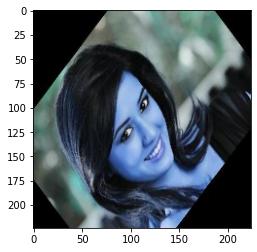

<Figure size 432x288 with 0 Axes>

SOURCE: class: Angelina, file: Angelina/30.jpg
PREDICTED: class: Emma Stone, confidence: 0.915035


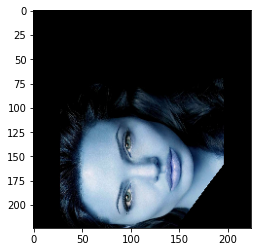

SOURCE: class: Disha Patani, file: Disha Patani/336.jpg
PREDICTED: class: Akshay Kumar, confidence: 0.955032


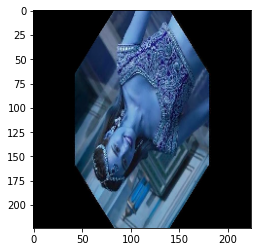

<Figure size 432x288 with 0 Axes>

SOURCE: class: Angelina, file: Angelina/38.jpg
PREDICTED: class: Akshay Kumar, confidence: 0.940247


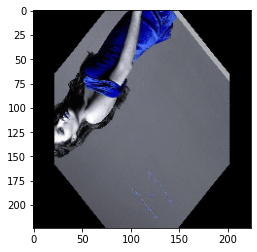

<Figure size 432x288 with 0 Axes>

SOURCE: class: Shirley, file: Shirley/17.jpg
PREDICTED: class: Shirley, confidence: 0.967108


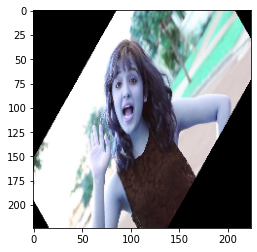

<Figure size 432x288 with 0 Axes>

In [35]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

## Save the Model
Now that you've trained the model, export it as a saved model

In [36]:
import time
t = time.time()

export_path = "/content/drive/My Drive/Face Recognition /Model/{}".format("face_reco")
tf.keras.experimental.export_saved_model(model, export_path)


AttributeError: ignored